In [1]:
import torch
import torch.nn as nn
import torch.autograd as grad

import numpy as np
from torch.utils.data import TensorDataset, DataLoader


In [2]:
# stock data load
import pandas as pd
import os 

df = pd.read_csv('stock.csv')
df


,Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012
...,...,...,...,...,...
727,599.992707,604.832763,562.192568,147100,567.002574
728,558.712504,568.452595,558.712504,7900,567.162558
729,566.892592,567.002574,556.932537,10800,556.972503
730,561.202549,566.432590,558.672539,41200,559.992565


In [3]:
# data preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume']] = scaler_x.fit_transform(df[['Open', 'High', 'Low', 'Volume']])
df[['Close']] = scaler_y.fit_transform(df[['Close']])



In [4]:
df = pd.DataFrame(df, columns = ['Open', 'High', 'Low', 'Volume', 'Close'])


In [5]:
# split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size = 0.3, shuffle=False, random_state=2023)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(512, 4) (512,) (220, 4) (220,)


In [6]:
X_train

,Open,High,Low,Volume
0,0.973336,0.975432,1.000000,0.111123
1,0.956900,0.959881,0.980354,0.142502
2,0.947896,0.949273,0.972505,0.114170
3,0.946235,0.945227,0.971008,0.116169
4,0.945186,0.945227,0.963761,0.093726
...,...,...,...,...
507,0.152059,0.156152,0.157078,0.144205
508,0.141918,0.155892,0.163064,0.169615
509,0.124142,0.141180,0.138248,0.144510
510,0.118459,0.122768,0.134448,0.122775


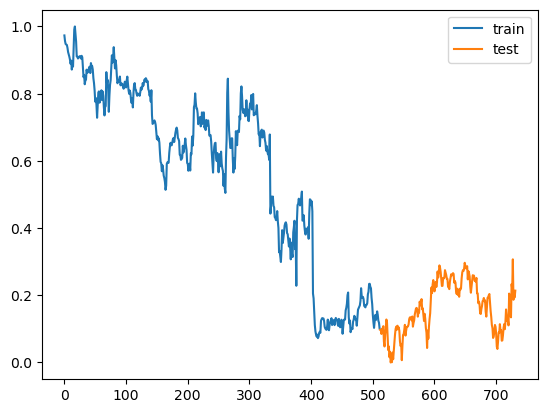

In [7]:
# 잘 분류되었는지 확인
import matplotlib.pyplot as plt
X_train['Open'].plot(label = 'train')
X_test['Open'].plot(label = 'test')
plt.legend()
plt.show()

In [8]:
# 5일 간의 데이터로 다음날의 종가를 예측하도록 데이터를 만들어줍니다.
def build_data(x_data, y_data, time_series):
    dataX = []
    dataY = []
    for i in range(len(x_data) - time_series):
        _x = x_data[i:i+time_series].values
        _y = y_data[i+time_series]
        
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)

In [9]:
train_x, train_y = build_data(X_train, y_train, 5)


In [10]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [11]:
test_x, test_y = build_data(X_test, y_test, 5)

In [12]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(507, 5, 4) (507,) (215, 5, 4) (215,)


In [136]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, batch_size, output_dim = 1, layers = 1):
        super(LSTM, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = layers
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)
        
    def reset_hidden(self):
        self.hidden = (torch.zeros(self.num_layers, self.seq_len, self.hidden_dim))
        
    def forward(self, x):
        
        out, self.hidden = self.lstm(x)
        out = self.fc(out[:,-1,:]) # 마지막 step의 결과만 가져오면 됨
        return out

In [137]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [138]:
model = LSTM(4, 20, 5, 32, 1, 1).to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [139]:
train_x = torch.Tensor(train_x).to(device)
train_y = torch.Tensor(train_y).to(device)
test_x = torch.Tensor(test_x).to(device)
test_y = torch.Tensor(test_y).to(device)

In [140]:
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [141]:
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    model.reset_hidden()
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(X).to(device)
        loss = loss_func(y_pred, y)
        loss.backward()
        optimizer.step()
        
        print('Epoch: {:4d}/{} Cost: {:.6f}'.format(epoch, num_epochs, loss.item()))

c:\Users\kyeongtae\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\kyeongtae\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:    0/300 Cost: 0.618708
Epoch:    0/300 Cost: 0.473010
Epoch:    0/300 Cost: 0.502116
Epoch:    0/300 Cost: 0.442413
Epoch:    0/300 Cost: 0.303888
Epoch:    0/300 Cost: 0.233277
Epoch:    0/300 Cost: 0.273596
Epoch:    0/300 Cost: 0.210798
Epoch:    0/300 Cost: 0.249434
Epoch:    0/300 Cost: 0.280893
Epoch:    0/300 Cost: 0.095712
Epoch:    0/300 Cost: 0.046958
Epoch:    0/300 Cost: 0.031299
Epoch:    0/300 Cost: 0.003138
Epoch:    0/300 Cost: 0.002121
Epoch:    0/300 Cost: 0.001671
Epoch:    1/300 Cost: 0.394853
Epoch:    1/300 Cost: 0.291889
Epoch:    1/300 Cost: 0.313958
Epoch:    1/300 Cost: 0.271759
Epoch:    1/300 Cost: 0.175161
Epoch:    1/300 Cost: 0.125417
Epoch:    1/300 Cost: 0.152092
Epoch:    1/300 Cost: 0.107926
Epoch:    1/300 Cost: 0.132956
Epoch:    1/300 Cost: 0.150495
Epoch:    1/300 Cost: 0.040788
Epoch:    1/300 Cost: 0.012528
Epoch:    1/300 Cost: 0.027988
Epoch:    1/300 Cost: 0.019847
Epoch:    1/300 Cost: 0.015993
Epoch:    1/300 Cost: 0.013346
Epoch:  

In [135]:
y_pred

tensor([[0.1333],
        [0.1313],
        [0.1202],
        [0.1115],
        [0.1158],
        [0.1193],
        [0.1276],
        [0.1336],
        [0.1346],
        [0.1266],
        [0.1183],
        [0.1058],
        [0.0959],
        [0.0886],
        [0.0851],
        [0.0801],
        [0.0822],
        [0.0781],
        [0.0838],
        [0.0884],
        [0.0998],
        [0.1123],
        [0.1238],
        [0.1319],
        [0.1356],
        [0.1400],
        [0.1417],
        [0.1379],
        [0.1298],
        [0.1176],
        [0.1110],
        [0.0997],
        [0.0920],
        [0.0978],
        [0.1067],
        [0.1169],
        [0.1277],
        [0.1315],
        [0.1318],
        [0.1327],
        [0.1370],
        [0.1391],
        [0.1415],
        [0.1445],
        [0.1507],
        [0.1534],
        [0.1554],
        [0.1565],
        [0.1561],
        [0.1528],
        [0.1515],
        [0.1503],
        [0.1527],
        [0.1577],
        [0.1645],
        [0

In [142]:
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [143]:
model.reset_hidden()
model.eval()

with torch.no_grad():
    loss = 0
    y_pred = model(test_x).to(device)
    cost = loss_func(y_pred, test_y)
    print('Cost: {:.6f}'.format(cost.item()))
    

Cost: 0.009209


c:\Users\kyeongtae\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([215])) that is different to the input size (torch.Size([215, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


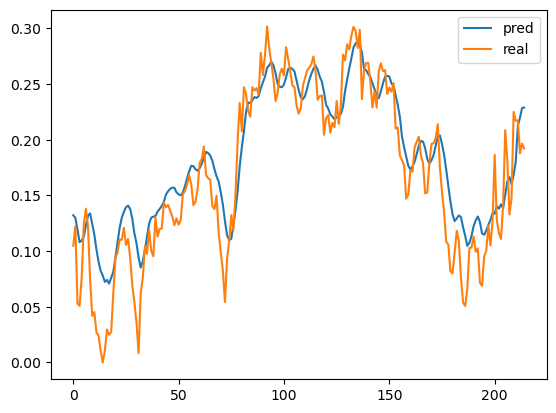

In [144]:
plt.plot(y_pred.cpu().numpy(), label = 'pred')
plt.plot(test_y.cpu().numpy(), label = 'real')
plt.legend()
plt.show()

In [145]:
y_pred_inverse = scaler_y.inverse_transform(y_pred.cpu().numpy())
y_true_inverse = scaler_y.inverse_transform(test_y.view(-1, 1).cpu().numpy())


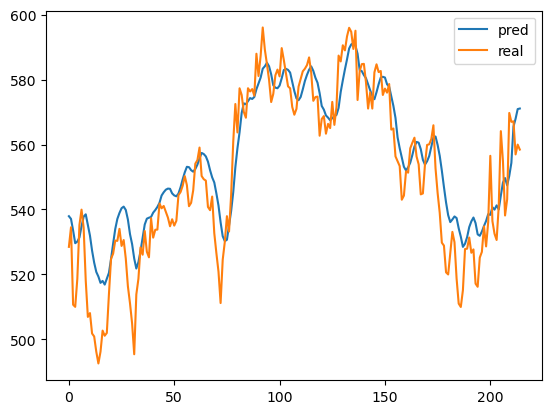

In [146]:
plt.plot(y_pred_inverse, label = 'pred')
plt.plot(y_true_inverse, label = 'real')
plt.legend()
plt.show()

In [147]:
from sklearn.metrics import mean_squared_error as MSE
print(MSE(y_true_inverse, y_pred_inverse))

114.90955
